# Spectral Nonogram Puzzle Generation and Solution

This notebook outlines the steps to generate a spectral nonogram puzzle and solve it using convex optimization techniques. The puzzle involves assigning colors to a 2D grid based on given row and column sums for each color. The solution process is divided into two main parts: solving the primal problem and the dual problem.

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# import gurobipy

# Puzzle Initialization

The spectral nonogram puzzle is initialized by randomly assigning colors to a \( N \times N \) grid. We then compute the colored sums for each row and column. The initialization process is performed by the `initialize_nonogram(N, colors)` function, which returns the grid and the color sums.

## Function definitions

In [2]:
def initialize_nonogram(N, colors):
    """
    Initializes a nonogram grid with random colors and computes the row and column sums for each color.

    Parameters:
    N (int): The size of the grid (N x N).
    colors (dict): A dictionary of colors and their corresponding labels.

    Returns:
    tuple: A tuple containing the initialized grid and a dictionary with the row and column sums for each color.
    """
    # Initialize the grid with random colors, excluding 'Vacant'
    actual_colors = [color for color in colors if color != 'Vacant']
    grid = np.random.choice(actual_colors, size=(N, N))

    # Compute the colored sums for each row and each column
    color_sums = {color: {'row': np.zeros(N, dtype=int), 'col': np.zeros(N, dtype=int)} for color in actual_colors}
    
    for color in actual_colors:
        # Mask the grid for the current color and calculate the sums
        mask = (grid == color)
        color_sums[color]['row'] = np.sum(mask, axis=1)
        color_sums[color]['col'] = np.sum(mask, axis=0)

    return grid, color_sums

def create_row_sum_matrix(N):
    """
    Creates a matrix representing the row sums of an N x N nonogram grid.

    Each row of the resulting matrix corresponds to a sum of a particular row in the grid,
    and each column corresponds to a particular pixel in the grid.

    Parameters:
    N (int): The size of the nonogram grid.

    Returns:
    np.ndarray: A matrix of size (N, N^2) where each row indicates the contribution
                of each pixel to the respective row sum.
    """
    # Initialize a matrix for row sums with zeros
    row_sum_matrix = np.zeros((N, N**2))
    # Each row in the grid contributes to one row sum
    for i in range(N):
        row_sum_matrix[i, i::N] = 1
    return row_sum_matrix

def create_column_sum_matrix(N):
    """
    Creates a matrix representing the column sums of an N x N nonogram grid.

    Each row of the resulting matrix corresponds to a sum of a particular column in the grid,
    and each column corresponds to a particular pixel in the grid.

    Parameters:
    N (int): The size of the nonogram grid.

    Returns:
    np.ndarray: A matrix of size (N, N^2) where each row indicates the contribution
                of each pixel to the respective column sum.
    """
    # Initialize a matrix for column sums with zeros
    column_sum_matrix = np.zeros((N, N**2))
    # Each column in the grid contributes to one column sum
    for i in range(N):
        column_sum_matrix[i, i*N:(i+1)*N] = 1
    return column_sum_matrix

def create_system_matrix(N):
    """
    Generates the system matrix A for an N x N nonogram grid that maps grid colors to their row and column sums.

    Parameters:
    N (int): The size of the nonogram grid (N x N).

    Returns:
    np.ndarray: The combined system matrix A of size (2N, N^2) where the first N rows represent the column sums
                and the next N rows represent the row sums.
    """
    # Create column and row sum matrices
    column_sum_matrix = create_column_sum_matrix(N)
    row_sum_matrix = create_row_sum_matrix(N)
    # Stack them to form the system matrix A
    A = np.vstack((column_sum_matrix, row_sum_matrix))
    return A


def convert_sums_to_matrix_Y(color_sums, N):
    """
    Convert the color_sums dictionary to a matrix Y where each column represents the color sum vector y_i.

    Parameters:
    color_sums (dict): A dictionary with the row and column sums for each color.
    N (int): The size of the grid (N x N).

    Returns:
    np.ndarray: The matrix Y containing the color sum vectors.
    """
    # The number of colors is the number of keys in the color_sums dictionary
    num_colors = len(color_sums)
    
    # Initialize the matrix Y with size 2N x number of colors (column sums on top, row sums on bottom)
    Y = np.zeros((2 * N, num_colors))

    for idx, (color, sums) in enumerate(color_sums.items()):
        # Column sums go on top, row sums on the bottom
        Y[:N, idx] = sums['col']
        Y[N:, idx] = sums['row']

    return Y

def grid_to_matrix_X(grid, colors):
    """
    Convert a nonogram grid to the matrix X, where each column corresponds to a color.

    Parameters:
    grid (np.ndarray): The grid representing the nonogram.
    colors (dict): A dictionary of colors and their corresponding labels.

    Returns:
    np.ndarray: The matrix X with size num_pixels x num_colors.
    """
    N = grid.shape[0]  # Size of the grid (N x N)
    num_pixels = N * N
    num_colors = len(colors)
    
    # Initialize the matrix X
    X = np.zeros((num_pixels, num_colors))
    
    # Create a mapping of color to column index
    color_to_index = {color: i for i, color in enumerate(colors)}
    
    # Fill in the matrix X
    for i in range(N):
        for j in range(N):
            # Get the index of the current color in the matrix X
            color_index = color_to_index[grid[j, i]]
            # Set the corresponding entry in the matrix X to 1
            X[i * N + j, color_index] = 1
    
    return X

## Main block

In [3]:
N = 5  # Grid size

colors = {
    'R': (1, 0, 0),  # Red
    'G': (0, 1, 0),  # Green
    'B': (0, 0, 1),  # Blue
    'V': (1, 1, 1)   # Vacant or white
}

true_grid, true_color_sums = initialize_nonogram(N, colors)

A = create_system_matrix(N)
Y = convert_sums_to_matrix_Y(true_color_sums, N)

X_true = grid_to_matrix_X(true_grid, colors)

print(true_grid)
print(true_color_sums)
# print('A: \n', A)
# print('Y: \n', Y)
# print('X_true: \n', X_true)

[['V' 'B' 'R' 'R' 'G']
 ['R' 'G' 'B' 'V' 'V']
 ['G' 'G' 'B' 'B' 'R']
 ['V' 'R' 'V' 'R' 'V']
 ['V' 'R' 'G' 'V' 'B']]
{'R': {'row': array([2, 1, 1, 2, 1]), 'col': array([1, 2, 1, 2, 1])}, 'G': {'row': array([1, 1, 2, 0, 1]), 'col': array([1, 2, 1, 0, 1])}, 'B': {'row': array([1, 1, 2, 0, 1]), 'col': array([0, 1, 2, 1, 1])}, 'V': {'row': array([1, 2, 0, 3, 2]), 'col': array([3, 0, 1, 2, 2])}}


# Primal Problem Formulation

The primal problem aims to find the pixel intensities \( \mathbf{x}_i \) that correspond to the color channels, including a 'blank' channel for uncolored pixels. The mathematical formulation is as follows:

\[
\mathbf{A} \mathbf{x}_i = \mathbf{y}_i, \quad \forall i = 1, \dots, k+1 \quad \text{subject to} \quad \sum_{i=1}^{k+1} \mathbf{x}_i = \mathbf{1}
\]

Where \( \mathbf{A} \) maps the grid to the sums, \( \mathbf{x}_i \) are the pixel intensities, and \( \mathbf{y}_i \) are the aggregated sums for each color.

## Functions (definitions)

In [4]:
def solve_for_X(A, Y):
    """
    Solves a convex optimization problem using CVXPY to find the intensities of pixels for each color in a nonogram.

    The optimization aims to minimize the Frobenius norm of the difference between the product of A and X and the matrix Y,
    subject to the constraints that the sum of the intensities of each color for each pixel sums to 1.

    Parameters:
    A (np.ndarray): The matrix mapping the grid to the row and column sums.
    Y (np.ndarray): The matrix containing the target row and column sums for each color.

    Returns:
    np.ndarray: The optimized matrix X, representing the intensities of each color for each pixel.
    """
    num_pixels = A.shape[1]  # Number of pixels (N^2 for an N x N grid)
    num_colors = Y.shape[1]  # Number of colors (including the 'blank' channel)
    
    print(num_pixels)
    print(num_colors)
    
    # Create a variable for the intensities of each pixel for each color
    X = cp.Variable((num_pixels, num_colors))
    
    # The objective is to minimize the sum of the squares of (A * x_i - y_i) across all colors
    # objective = cp.Minimize(cp.norm(cp.hstack([A @ X[:, i] for i in range(num_colors)]) - Y, 'fro'))
    objective = cp.Minimize(cp.norm(A @ X - Y, 'fro'))
    
    # Constraints: each x_i should be between 0 and 1, and the sum across each row (pixel) should be 1
    constraints = [cp.sum(X, axis=1) == 1]
    constraints = [0 <= X, X <= 1]

    # Define and solve the problem
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS)

    return X.value

def print_matrices_side_by_side(X, X_true):
    """
    Prints two matrices side by side for easy comparison, formatting the values to two decimal places.

    Parameters:
    X (np.ndarray): The first matrix to be printed on the left side.
    X_true (np.ndarray): The second matrix (often the ground truth) to be printed on the right side.
    """
    # Stacking the two matrices horizontally
    stacked_matrix = np.hstack((X, X_true))

    # Formatting the matrix to print with 2 decimal places
    print("Matrix X (left) and Matrix X_true (right):")
    for row in stacked_matrix:
        print(" ".join(f"{val:.2f}" if isinstance(val, float) else str(val) for val in row))

## Main block

In [5]:
# solve
X_primal = solve_for_X(A, Y)

# print
print_matrices_side_by_side(X_primal, X_true)

25
4
Matrix X (left) and Matrix X_true (right):
0.27 0.19 0.00 0.50 0.00 0.00 0.00 1.00
0.15 0.19 0.00 0.84 1.00 0.00 0.00 0.00
0.15 0.42 -0.00 -0.00 0.00 1.00 0.00 0.00
0.27 0.00 -0.00 0.83 0.00 0.00 0.00 1.00
0.15 0.19 0.00 0.84 0.00 0.00 0.00 1.00
0.59 0.42 0.19 0.00 0.00 0.00 1.00 0.00
0.27 0.42 0.19 -0.00 0.00 1.00 0.00 0.00
0.27 0.73 0.42 -0.00 0.00 1.00 0.00 0.00
0.59 -0.00 0.00 -0.00 1.00 0.00 0.00 0.00
0.27 0.42 0.19 -0.00 1.00 0.00 0.00 0.00
0.27 0.19 0.42 0.17 1.00 0.00 0.00 0.00
0.15 0.19 0.42 0.16 0.00 0.00 1.00 0.00
0.15 0.42 0.73 0.00 0.00 0.00 1.00 0.00
0.27 0.00 -0.00 0.50 0.00 0.00 0.00 1.00
0.15 0.19 0.42 0.16 0.00 1.00 0.00 0.00
0.59 0.00 0.19 0.16 1.00 0.00 0.00 0.00
0.27 0.00 0.19 0.50 0.00 0.00 0.00 1.00
0.27 -0.00 0.42 -0.00 0.00 0.00 1.00 0.00
0.59 -0.00 0.00 0.84 1.00 0.00 0.00 0.00
0.27 0.00 0.19 0.50 0.00 0.00 0.00 1.00
0.27 0.19 0.19 0.16 0.00 1.00 0.00 0.00
0.15 0.19 0.19 0.50 0.00 0.00 0.00 1.00
0.15 0.42 0.42 -0.00 1.00 0.00 0.00 0.00
0.27 0.00 0.00 0.84

# Dual Problem Formulation

The dual problem is formulated to minimize a different objective function that depends on the dual variables \( \boldsymbol{\lambda}_i \) and \( \boldsymbol{\nu} \). The primal solution is recovered from the optimized dual variables.

The mathematical formulation is as follows:

\[
    \mbox{minimize} \quad \sum_{i=1}^{k} \| \left( \lambda_i + \nu \right) - A^T y_i \|_{\left( A^T A \right)^\dagger}^2 + \left( \| \lambda_i \|_1 + \lambda_i^T 1 \right) + 2 * \nu^T 1
\]


## Function definitions

In [6]:
def solve_dual_problem(A, Y):
    """
    Solves the dual of a convex optimization problem using CVXPY to find the pixel intensities X for a nonogram puzzle. 

    The dual formulation involves minimizing a combination of quadratic terms 
    involving dual variables Lambda and nu, and linear terms. The primal 
    solution is recovered from the optimized dual variables by applying a 
    transformation based on the sign of the Lambda values.

    Parameters:
    A (np.ndarray): The matrix A mapping the grid to the sums.
    Y (np.ndarray): The matrix Y containing the color sum vectors.

    Returns:
    np.ndarray: The matrix X_star, containing the primal pixel intensities for each color channel, recovered from the dual solution.
    """
    num_pixels = A.shape[1]  # Number of pixels (N^2 for an N x N grid)
    num_colors = Y.shape[1]  # Number of colors (excluding 'Vacant')
    
    # Compute the pseudoinverse of (A^T A)
    ATA_pinv = np.linalg.pinv(A.T @ A)
    
    # Define the dual variables Lambda for each color and nu
    Lambda = cp.Variable((num_pixels, num_colors))
    nu = cp.Variable(num_pixels)
    
    # Construct the dual objective function
    dual_objective_terms = []
    for i in range(num_colors):
        term = 0.5 * cp.quad_form(Lambda[:, i] + nu - A.T @ Y[:, i], ATA_pinv)
        term += 0.5 * (cp.norm1(Lambda[:, i]) + cp.sum(Lambda[:, i]))
        dual_objective_terms.append(term)
    dual_objective = cp.sum(dual_objective_terms) + cp.sum(nu)
    
    # Dual problem objective
    dual_objective = cp.Minimize(dual_objective)
    
    # Solve the dual problem (available solvers: ['CLARABEL', 'ECOS', 'ECOS_BB', 'GUROBI', 'OSQP', 'SCIPY', 'SCS'])
    dual_prob = cp.Problem(dual_objective)
    dual_prob.solve(solver=cp.CLARABEL, verbose=False)
    
    # Threshold Lambda values
    tol = 1e-9
    Lambda_value = Lambda.value
    Lambda_value[np.abs(Lambda_value) < tol] = 0
    
    # Recover the primal solution X from the optimized dual variables
    X_star = 0.5 * (np.sign(Lambda_value) + 1)
    
    return X_star

## Main block

In [7]:
# solve
X_dual = solve_dual_problem(A, Y)

# print
print_matrices_side_by_side(X_dual, X_true)

Matrix X (left) and Matrix X_true (right):
0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00
0.00 0.00 0.00 1.00 1.00 0.00 0.00 0.00
0.00 0.00 0.00 0.50 0.00 1.00 0.00 0.00
0.00 0.00 0.00 1.00 0.00 0.00 0.00 1.00
0.00 0.00 0.00 1.00 0.00 0.00 0.00 1.00
0.50 0.00 0.00 0.00 0.00 0.00 1.00 0.00
0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00
0.00 0.50 0.00 0.00 0.00 1.00 0.00 0.00
0.50 0.00 0.00 0.00 1.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00
0.50 0.00 0.50 0.00 1.00 0.00 0.00 0.00
0.00 0.00 0.50 0.00 0.00 0.00 1.00 0.00
0.00 0.00 0.50 0.00 0.00 0.00 1.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00
0.00 0.00 0.50 0.00 0.00 1.00 0.00 0.00
0.50 0.00 0.00 0.00 1.00 0.00 0.00 0.00
0.00 0.00 0.00 0.50 0.00 0.00 0.00 1.00
0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00
0.50 0.00 0.00 0.50 1.00 0.00 0.00 0.00
0.00 0.00 0.00 0.50 0.00 0.00 0.00 1.00
0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00
0.00 0.00 0.00 0.50 0.00 0.00 0.00 1.00
0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00
0.00 0.00 0.00 0.50 0.00 0.00 0.00 1.

# Results and Comparison

The notebook then compares the primal and dual solutions to the true color intensities of the initialized grid. We visualize and evaluate the accuracy of the solutions. The solutions are analyzed, and the performance of the primal and dual approaches is discussed, concluding with insights into the effectiveness of convex optimization in solving the spectral nonogram puzzle.

## Function definitions

In [8]:
def interpolate_color(intensities, color_palette):
    """
    Interpolates a color based on the given intensities and a color palette.

    Parameters:
    intensities (np.ndarray): A 1D array of intensities for the colors.
    color_palette (np.ndarray): A 2D array where each row is a color in the palette.

    Returns:
    np.ndarray: The interpolated color as an RGB array.
    """
    # Normalize intensities to sum to 1
    if np.sum(intensities) > 0:
        normalized_intensities = intensities / np.sum(intensities)
    else:
        normalized_intensities = intensities  # All zeros, remains the same
    color = np.dot(normalized_intensities, color_palette)
    return color

def visualize_solutions(X_primal, X_dual, X, colors):
    """
    Visualizes the primal and dual solutions alongside the true grid for a nonogram puzzle.
    It maps pixel intensities to colors to produce colored grids for comparison.

    Parameters:
    X_primal (np.ndarray): The matrix X containing the primal pixel intensities for each color channel.
    X_dual (np.ndarray): The matrix X containing the dual pixel intensities for each color channel.
    X_true (np.ndarray): The matrix X containing the true pixel intensities for each color channel.
    colors (dict): A dictionary of color labels to RGB values.

    Returns:
    None: This function plots the primal, dual, and true solutions.
    """
    N = int(np.sqrt(X_primal.shape[0]))  # Assuming X_primal is of shape (N^2, num_colors)
    num_colors = X_primal.shape[1]
    
    # Convert the color dictionary to a color palette array
    # Assume 'V' or 'Vacant' is the last color in the color dictionary
    color_palette = np.array([colors[key] for key in sorted(colors.keys()) if key != 'V'] + [colors['V']])
    
    # Initialize the colored grids
    primal_colored_grid = np.zeros((N, N, 3))
    dual_colored_grid = np.zeros((N, N, 3))
    true_colored_grid = np.zeros((N, N, 3))
    
    # Map each pixel's intensity to a color
    for i in range(N):
        for j in range(N):
            primal_intensities = X_primal[i * N + j]
            dual_intensities = X_dual[i * N + j]
            true_intensities = X_true[i * N + j]
            
            primal_colored_grid[i, j] = interpolate_color(primal_intensities, color_palette)
            dual_colored_grid[i, j] = interpolate_color(dual_intensities, color_palette)
            true_colored_grid[i, j] = interpolate_color(true_intensities, color_palette)

    # Plot the grids
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(primal_colored_grid)
    axes[0].set_title('Primal Solution')
    axes[0].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    axes[1].imshow(dual_colored_grid)
    axes[1].set_title('Dual Solution')
    axes[1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    axes[2].imshow(true_colored_grid)
    axes[2].set_title('True Grid')
    axes[2].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ground_truth:  0.0
primal:  4.929524362306473e-06
dual:  5.385164807134504


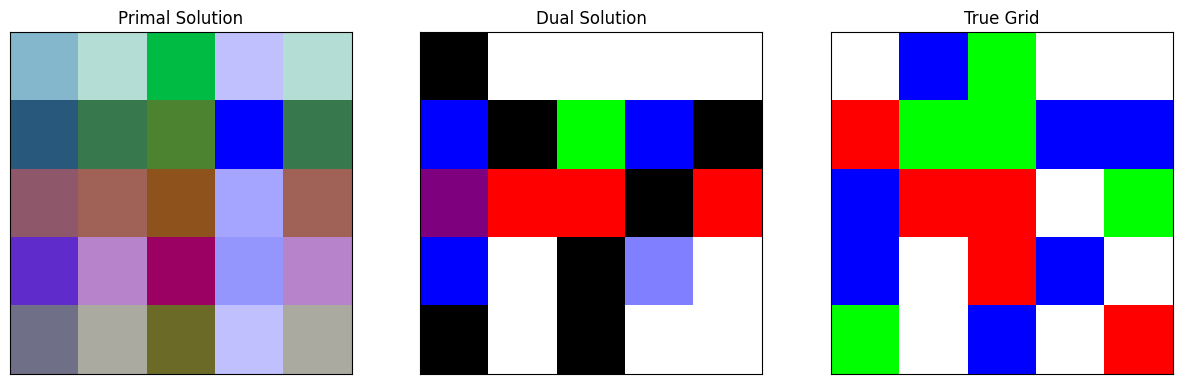

In [9]:
print('ground_truth: ', np.linalg.norm(A @ X_true - Y, 'fro'))
print('primal: ', np.linalg.norm(A @ X_primal - Y, 'fro'))
print('dual: ', np.linalg.norm(A @ X_dual - Y, 'fro'))

visualize_solutions(X_primal, X_dual, X_true, colors)